In [ ]:
import kagglehub
sumanthvrao_daily_climate_time_series_data_path = kagglehub.dataset_download('sumanthvrao/daily-climate-time-series-data')

print('Data source import complete.')


Using Colab cache for faster access to the 'daily-climate-time-series-data' dataset.
Data source import complete.


<div style="
display:flex;
align-items:center;
justify-content:center;
gap:20px;
padding:22px;
border-radius:14px;
background: linear-gradient(135deg, #373B44, #4286f4);
">

  <img src="https://cdn-icons-png.flaticon.com/512/1163/1163661.png"
       width="70" />

  <h1 style="
  color:white;
  font-size:34px;
  font-weight:bold;
  margin:0;">
          Weather Temperature Forecasting Using Machine Learning Models

  </h1>

</div>



 ****This project focuses on predicting daily mean temperature using historical weather data.****
****Two models—Linear Regression and XGBoost—are trained and evaluated to compare their forecasting accuracy.****
****The goal is to identify the most reliable approach for modeling temperature trends and understanding the underlying data patterns.****

<h1 style="
font-size:32px;
font-weight:bold;
background: linear-gradient(90deg, #3a7bd5, #6a11cb, #1f1c2c);
-webkit-background-clip: text;
color: transparent;
text-align:center;">
 ________________________________________________
 </h1>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
import xgboost as xgb

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [ ]:
import os

# read the data

# Construct the full paths to the CSV files using the downloaded dataset path
train_path_local = os.path.join(sumanthvrao_daily_climate_time_series_data_path, 'DailyDelhiClimateTrain.csv')
test_path_local = os.path.join(sumanthvrao_daily_climate_time_series_data_path, 'DailyDelhiClimateTest.csv')

df_train = pd.read_csv(train_path_local)
df_test = pd.read_csv(test_path_local)

df_train['date'] = pd.to_datetime(df_train['date'])
df_test['date'] = pd.to_datetime(df_test['date'])

df_train.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [ ]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)



<div style="
background:#2c3e50;
color:white;
padding:12px 20px;
font-size:26px;
border-radius:8px;
margin:15px 0;
text-align:center;">
Exploratory Data Analysis
</div>


In [ ]:
print(df_train.shape)


df_train.info()

(1462, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          1462 non-null   datetime64[ns]
 1   meantemp      1462 non-null   float64       
 2   humidity      1462 non-null   float64       
 3   wind_speed    1462 non-null   float64       
 4   meanpressure  1462 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 57.2 KB


In [ ]:
df_train.describe().T

,count,mean,min,25%,50%,75%,max,std
date,1462,2015-01-01 12:00:00,2013-01-01 00:00:00,2014-01-01 06:00:00,2015-01-01 12:00:00,2016-01-01 18:00:00,2017-01-01 00:00:00,NaN
meantemp,1462.0,25.495521,6.0,18.857143,27.714286,31.305804,38.714286,7.348103
humidity,1462.0,60.771702,13.428571,50.375,62.625,72.21875,100.0,16.769652
wind_speed,1462.0,6.802209,0.0,3.475,6.221667,9.238235,42.22,4.561602
meanpressure,1462.0,1011.104548,-3.041667,1001.580357,1008.563492,1014.944901,7679.333333,180.231668


In [ ]:
print(df_train.isnull().sum())
print(df_test.isnull().sum())

date            0
meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64
date            0
meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64


In [ ]:
numeric_cols = ['meantemp', 'humidity', 'wind_speed', 'meanpressure']


In [ ]:
for col in numeric_cols:
    q1 = df_train[col].quantile(0.25)
    q3 = df_train[col].quantile(0.75)
    iqr = q3 - q1
    outliers = df_train[(df_train[col] < q1 - 1.5*iqr) | (df_train[col] > q3 + 1.5*iqr)]
    print(f"{col}: {len(outliers)} outliers")


meantemp: 0 outliers
humidity: 2 outliers
wind_speed: 30 outliers
meanpressure: 9 outliers


In [ ]:
for col in numeric_cols:
    q1 = df_test[col].quantile(0.25)
    q3 = df_test[col].quantile(0.75)
    iqr = q3 - q1
    outliers = df_test[(df_test[col] < q1 - 1.5*iqr) | (df_test[col] > q3 + 1.5*iqr)]
    print(f"{col}: {len(outliers)} outliers")


meantemp: 0 outliers
humidity: 0 outliers
wind_speed: 2 outliers
meanpressure: 1 outliers


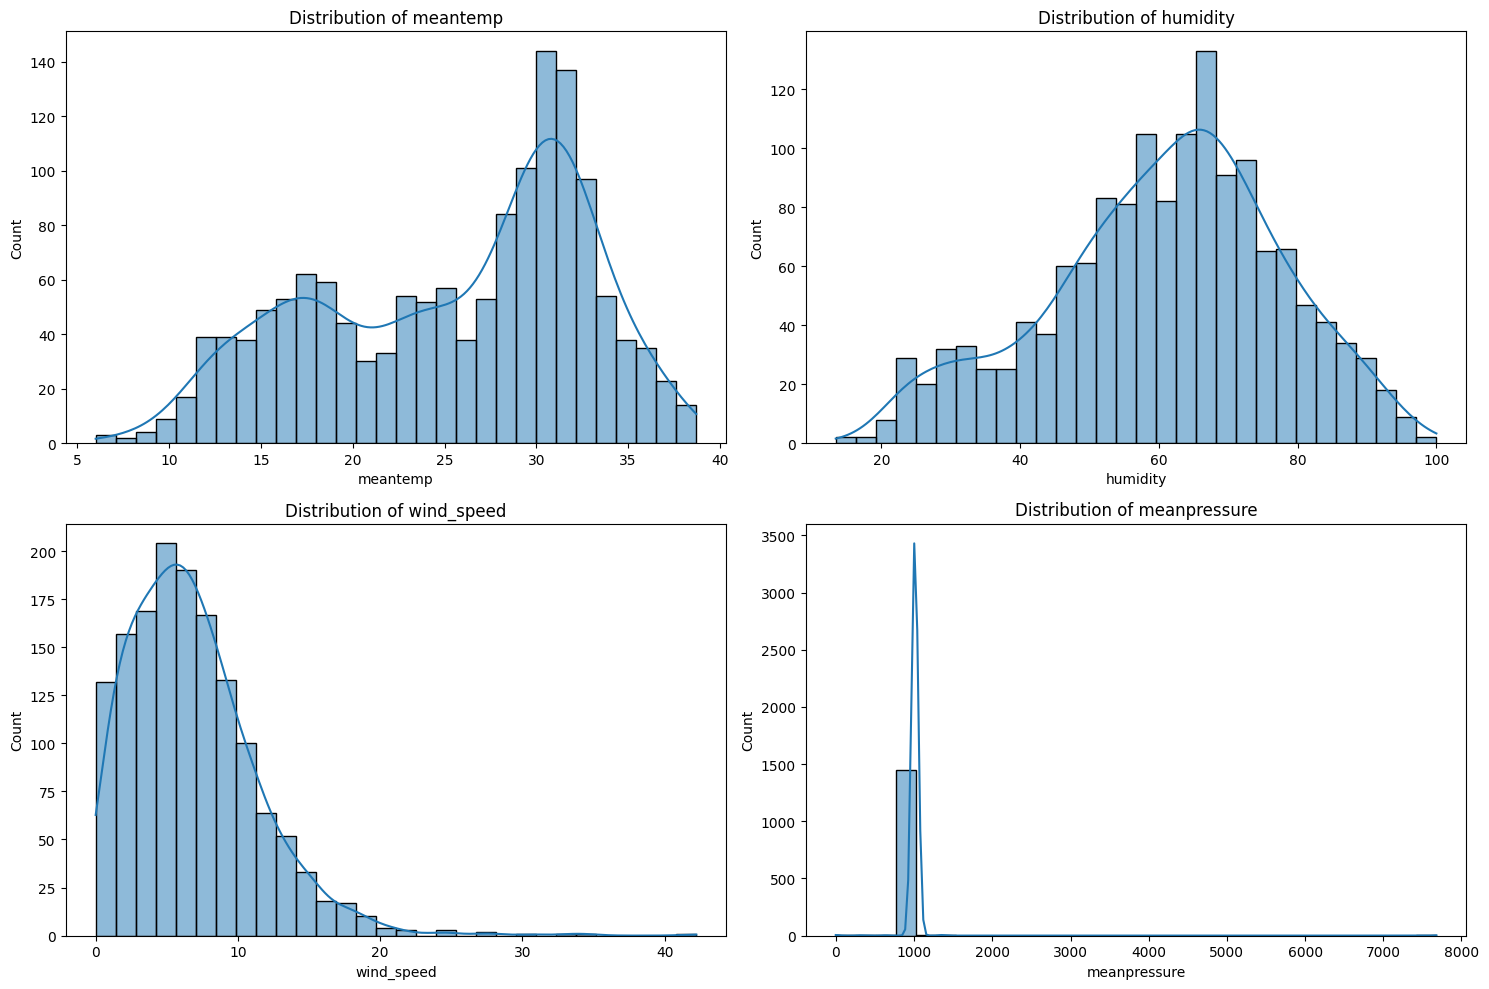

In [ ]:


plt.figure(figsize=(15,10))
for i, col in enumerate(numeric_cols):
    plt.subplot(2,2,i+1)
    sns.histplot(df_train[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()


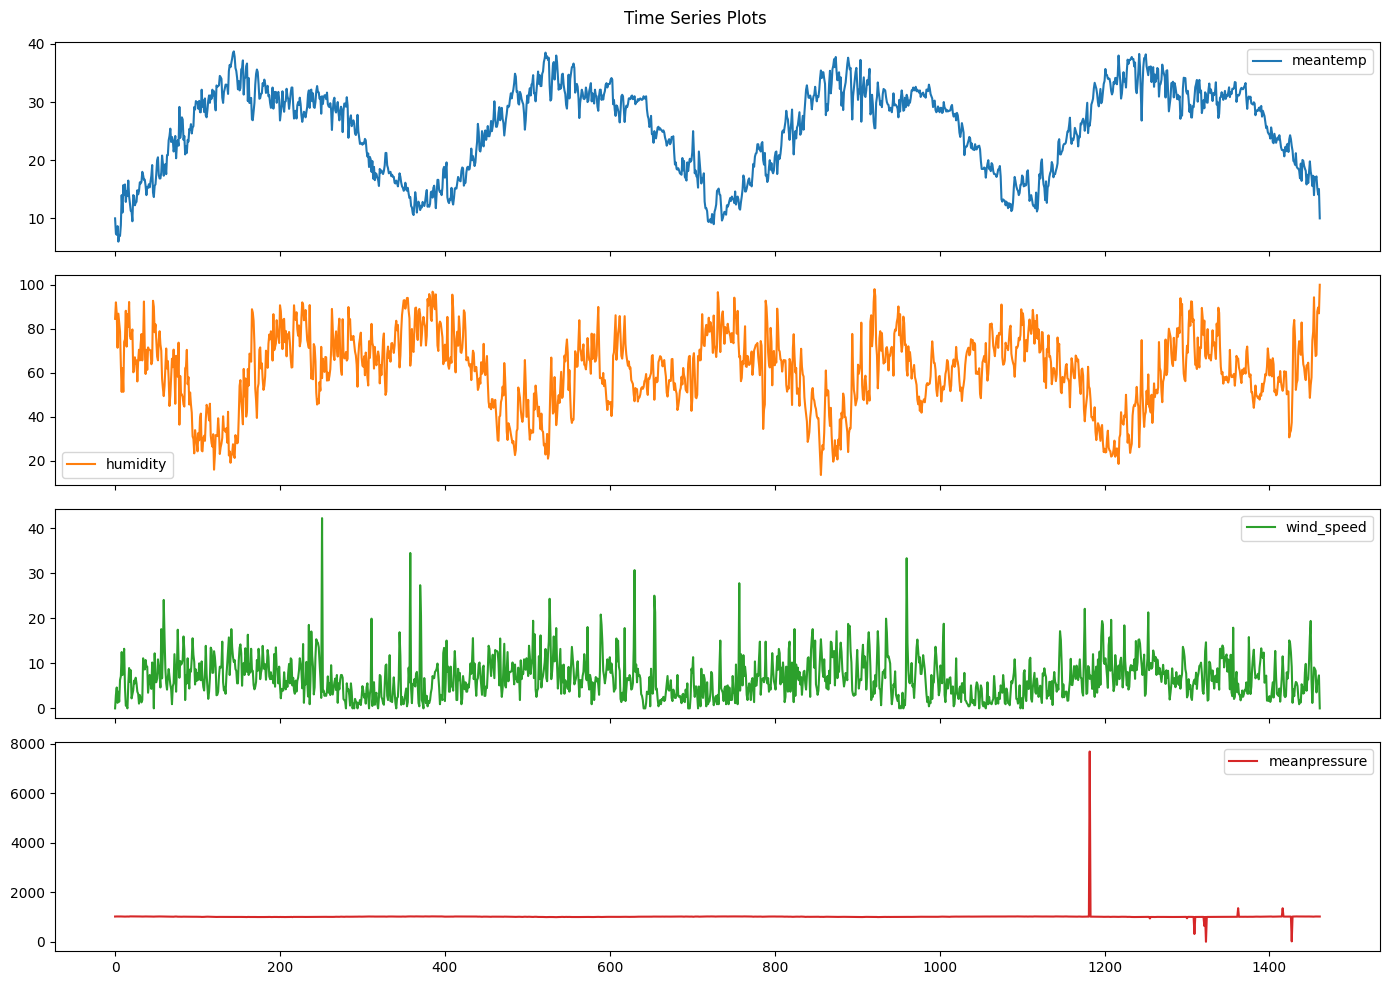

In [ ]:
df_train[numeric_cols].plot(subplots=True, figsize=(14,10), title="Time Series Plots")
plt.tight_layout()
plt.show()


In [ ]:
df_train['month'] = df_train['date'].dt.month
df_train['day_of_week'] = df_train['date'].dt.dayofweek
df_train['day_of_year'] = df_train['date'].dt.dayofyear
df_train.head(20)

,date,meantemp,humidity,wind_speed,meanpressure,month,day_of_week,day_of_year
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667,1,1,1
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000,1,2,2
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667,1,3,3
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667,1,4,4
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000,1,5,5
5,2013-01-06,7.000000,82.800000,1.480000,1018.000000,1,6,6
6,2013-01-07,7.000000,78.600000,6.300000,1020.000000,1,0,7
7,2013-01-08,8.857143,63.714286,7.142857,1018.714286,1,1,8
8,2013-01-09,14.000000,51.250000,12.500000,1017.000000,1,2,9
9,2013-01-10,11.000000,62.000000,7.400000,1015.666667,1,3,10


In [ ]:
df_test['month'] = df_test['date'].dt.month
df_test['day_of_week'] = df_test['date'].dt.dayofweek
df_test['day_of_year'] = df_test['date'].dt.dayofyear
df_test.head(20)

,date,meantemp,humidity,wind_speed,meanpressure,month,day_of_week,day_of_year
0,2017-01-01,15.913043,85.869565,2.743478,59.000000,1,6,1
1,2017-01-02,18.500000,77.222222,2.894444,1018.277778,1,0,2
2,2017-01-03,17.111111,81.888889,4.016667,1018.333333,1,1,3
3,2017-01-04,18.700000,70.050000,4.545000,1015.700000,1,2,4
4,2017-01-05,18.388889,74.944444,3.300000,1014.333333,1,3,5
5,2017-01-06,19.318182,79.318182,8.681818,1011.772727,1,4,6
6,2017-01-07,14.708333,95.833333,10.041667,1011.375000,1,5,7
7,2017-01-08,15.684211,83.526316,1.950000,1015.550000,1,6,8
8,2017-01-09,14.571429,80.809524,6.542857,1015.952381,1,0,9
9,2017-01-10,12.111111,71.944444,9.361111,1016.888889,1,1,10


In [ ]:
for col in df_train.columns:
    print(col, ":", df_train[col].nunique())


df_train.info()


date : 1462
meantemp : 617
humidity : 897
wind_speed : 730
meanpressure : 626
month : 12
day_of_week : 7
day_of_year : 366
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          1462 non-null   datetime64[ns]
 1   meantemp      1462 non-null   float64       
 2   humidity      1462 non-null   float64       
 3   wind_speed    1462 non-null   float64       
 4   meanpressure  1462 non-null   float64       
 5   month         1462 non-null   int32         
 6   day_of_week   1462 non-null   int32         
 7   day_of_year   1462 non-null   int32         
dtypes: datetime64[ns](1), float64(4), int32(3)
memory usage: 74.4 KB


In [ ]:
for col in df_test.columns:
    print(col, ":", df_test[col].nunique())


df_train.info()

date : 114
meantemp : 105
humidity : 109
wind_speed : 109
meanpressure : 109
month : 4
day_of_week : 7
day_of_year : 114
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          1462 non-null   datetime64[ns]
 1   meantemp      1462 non-null   float64       
 2   humidity      1462 non-null   float64       
 3   wind_speed    1462 non-null   float64       
 4   meanpressure  1462 non-null   float64       
 5   month         1462 non-null   int32         
 6   day_of_week   1462 non-null   int32         
 7   day_of_year   1462 non-null   int32         
dtypes: datetime64[ns](1), float64(4), int32(3)
memory usage: 74.4 KB


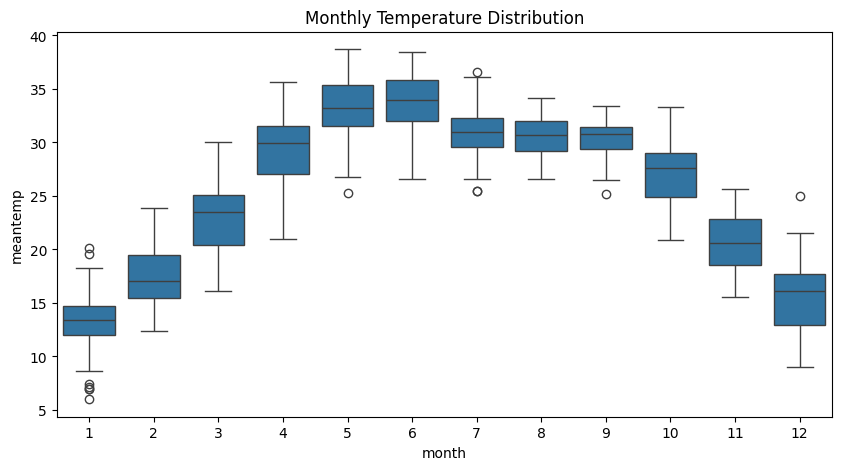

In [ ]:
plt.figure(figsize=(10,5))
sns.boxplot(x='month', y='meantemp', data=df_train)
plt.title('Monthly Temperature Distribution')
plt.show()


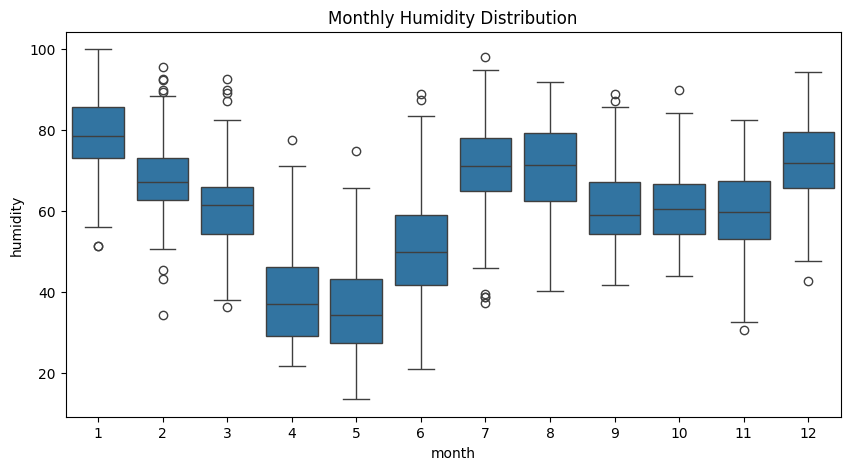

In [ ]:
plt.figure(figsize=(10,5))
sns.boxplot(x='month', y='humidity', data=df_train)
plt.title('Monthly Humidity Distribution')
plt.show()


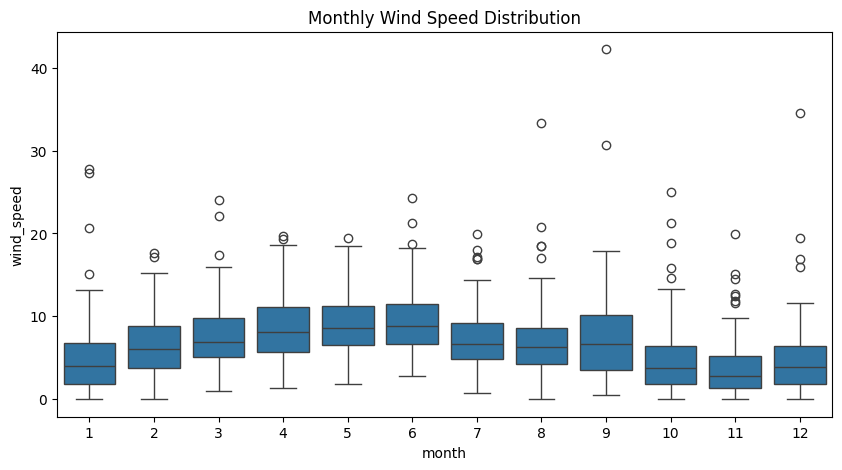

In [ ]:
plt.figure(figsize=(10,5))
sns.boxplot(x='month', y='wind_speed', data=df_train)
plt.title('Monthly Wind Speed Distribution')
plt.show()


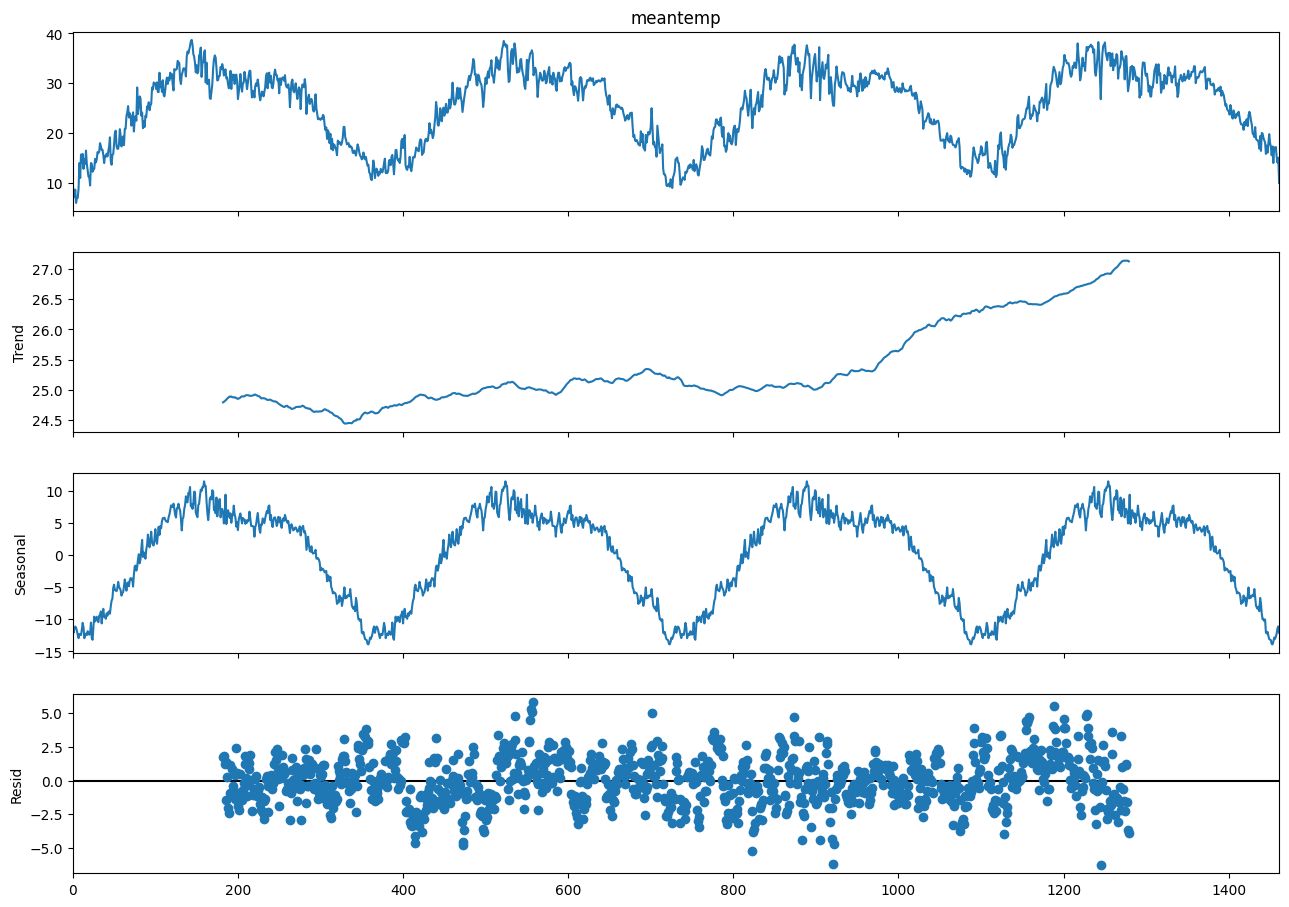

In [ ]:
#df_train['date'] = pd.to_datetime(df_train['date'])
#df_train.set_index('date', inplace=True)


result = seasonal_decompose(df_train['meantemp'], model='additive', period=365)

fig = result.plot()
fig.set_size_inches(14, 10)
plt.show()


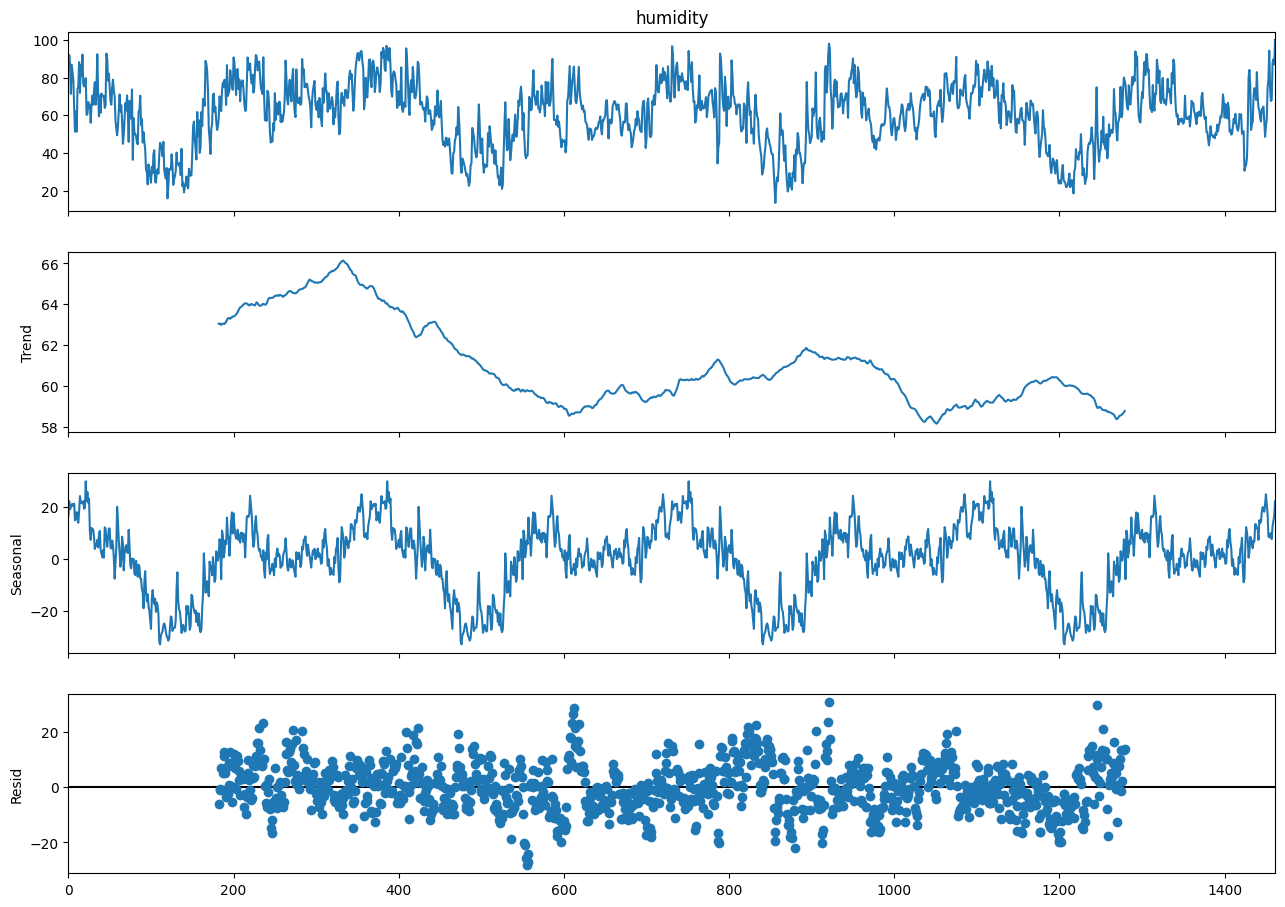

In [ ]:
result = seasonal_decompose(df_train['humidity'], model='additive', period=365)

fig = result.plot()
fig.set_size_inches(14, 10)
plt.show()

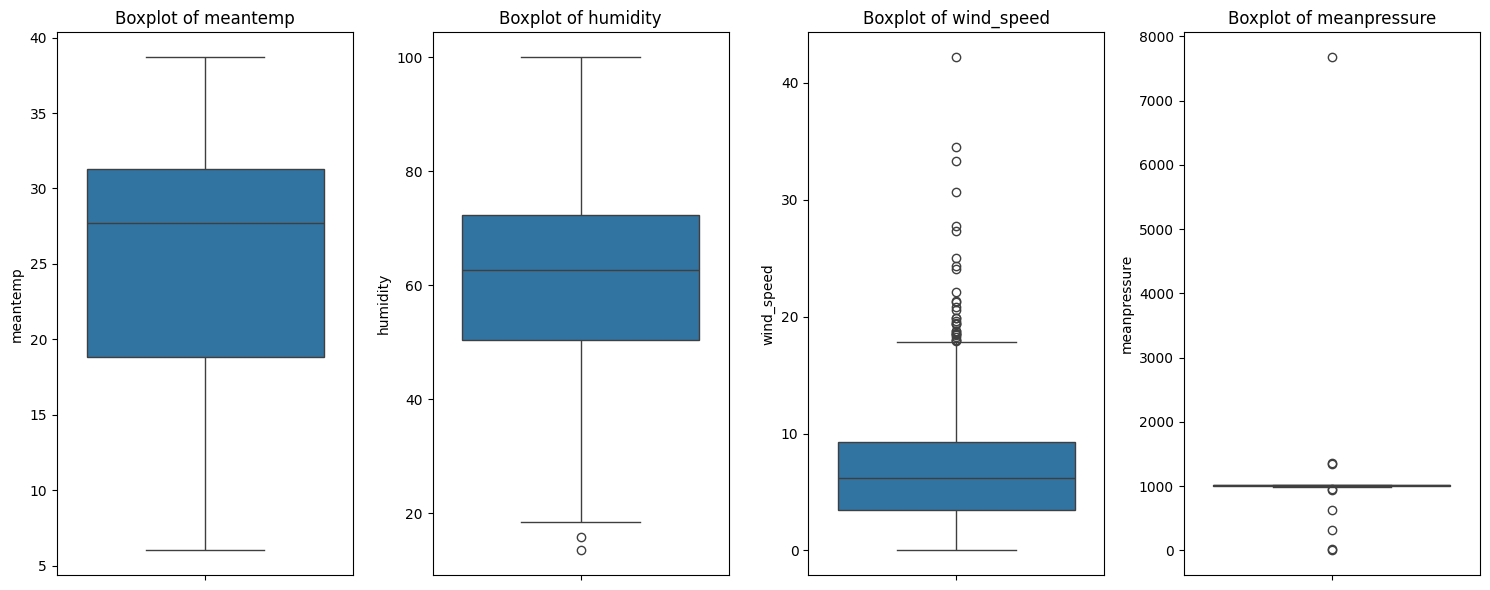

In [ ]:
plt.figure(figsize=(15,6))
for i, col in enumerate(numeric_cols):
    plt.subplot(1,4,i+1)
    sns.boxplot(y=df_train[col])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()




<div style="
background:#2c3e50;
color:white;
padding:12px 20px;
font-size:26px;
border-radius:8px;
margin:15px 0;
text-align:center;">
    Preprocessing the data

</div>


In [ ]:
#Handle the outliers in df_train


for col in numeric_cols:
    Q1 = df_train[col].quantile(0.25)
    Q3 = df_train[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5*IQR
    upper = Q3 + 1.5*IQR
    df_train[col] = df_train[col].clip(lower, upper)




for col in numeric_cols:
    q1 = df_train[col].quantile(0.25)
    q3 = df_train[col].quantile(0.75)
    iqr = q3 - q1
    outliers = df_train[(df_train[col] < q1 - 1.5*iqr) | (df_train[col] > q3 + 1.5*iqr)]
    print(f"{col}: {len(outliers)} outliers")


meantemp: 0 outliers
humidity: 0 outliers
wind_speed: 0 outliers
meanpressure: 0 outliers


In [ ]:
#Handle the outliers in df_test


for col in numeric_cols:
    Q1 = df_test[col].quantile(0.25)
    Q3 = df_test[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5*IQR
    upper = Q3 + 1.5*IQR
    df_test[col] = df_test[col].clip(lower, upper)




for col in numeric_cols:
    q1 = df_test[col].quantile(0.25)
    q3 = df_test[col].quantile(0.75)
    iqr = q3 - q1
    outliers = df_test[(df_test[col] < q1 - 1.5*iqr) | (df_test[col] > q3 + 1.5*iqr)]
    print(f"{col}: {len(outliers)} outliers")


meantemp: 0 outliers
humidity: 0 outliers
wind_speed: 0 outliers
meanpressure: 0 outliers


In [ ]:
#Scaling the data

features = ['meantemp','humidity','wind_speed','meanpressure','month','day_of_week','day_of_year']


scaler = StandardScaler()

df_train_scaled = pd.DataFrame(scaler.fit_transform(df_train[features]), columns=features)

df_test_scaled = pd.DataFrame(scaler.transform(df_test[features]), columns=features)

df_train_scaled.head()

,meantemp,humidity,wind_speed,meanpressure,month,day_of_week,day_of_year
0,-2.109500,1.416115,-1.602411,0.967464,-1.599501,-1.001455,-1.724960
1,-2.463454,1.863795,-0.890344,1.244406,-1.599501,-0.501241,-1.715483
2,-2.495219,1.565342,-0.495282,1.356914,-1.599501,-0.001026,-1.706005
3,-2.291015,0.630188,-1.307708,1.162189,-1.599501,0.499188,-1.696527
4,-2.654044,1.555393,-0.718301,1.075645,-1.599501,0.999402,-1.687049



****We only apply the transform on the test set, using the mean and standard deviation calculated from the training set:****

****This simulates real-world conditions: the model has no prior knowledge of the test data and can only use what it learned from the training data.****


In [ ]:
df_test_scaled.head()

,meantemp,humidity,wind_speed,meanpressure,month,day_of_week,day_of_year
0,-1.304521,1.497865,-0.946861,-1.912169,-1.599501,1.499616,-1.724960
1,-0.952343,0.981700,-0.910788,1.306430,-1.599501,-1.501669,-1.715483
2,-1.141421,1.260256,-0.642634,1.313642,-1.599501,-1.001455,-1.706005
3,-0.925116,0.553585,-0.516390,0.971791,-1.599501,-0.501241,-1.696527
4,-0.967469,0.845738,-0.813881,0.794375,-1.599501,-0.001026,-1.687049



<div style="
background:#2c3e50;
color:white;
padding:12px 28px;
font-size:26px;
border-radius:8px;
margin:15px 0;
text-align:center;">
Linear Regression
</div>


In [ ]:
target = 'meantemp'
X_train = df_train_scaled.drop(columns=[target])
y_train = df_train_scaled[target]

X_test = df_test_scaled.drop(columns=[target])
y_test = df_test_scaled[target]

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

y_pred_lr= lr_model.predict(X_test)

mae_lr = mean_absolute_error(y_test, y_pred_lr)
mse_lr = mean_squared_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mse_lr) # Fix: Calculate RMSE by taking the square root of MSE
r2_lr = r2_score(y_test, y_pred_lr)


print("Linear Regression Performance:")
print("------------------------")
print(f"MAE =   {mae_lr:.2f}")
print(f"RMSE=   {rmse_lr:.2f}")
print(f"R² Score =  {r2_lr:.2f}")

Linear Regression Performance:
------------------------
MAE =   0.32
RMSE=   0.41
R² Score =  0.77


<div style="
background:#2c3e50;
color:white;
padding:12px 28px;
font-size:26px;
border-radius:8px;
margin:15px 0;
text-align:center;">
    XGBoost  Regressor
</div>


In [ ]:

target = 'meantemp'
X_train = df_train_scaled.drop(columns=[target])
y_train = df_train_scaled[target]

X_test = df_test_scaled.drop(columns=[target])
y_test = df_test_scaled[target]

xgb_model = xgb.XGBRegressor(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)

mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)



print("XGBoost Regressor Performance:")
print("------------------------")
print(f"RMSE =  {rmse_xgb:.2f}")
print(f"MAE  =  {mae_xgb:.2f}")
print(f"R² Score = {r2_xgb:.2f}")

XGBoost Regressor Performance:
------------------------
RMSE =  0.40
MAE  =  0.32
R² Score = 0.78


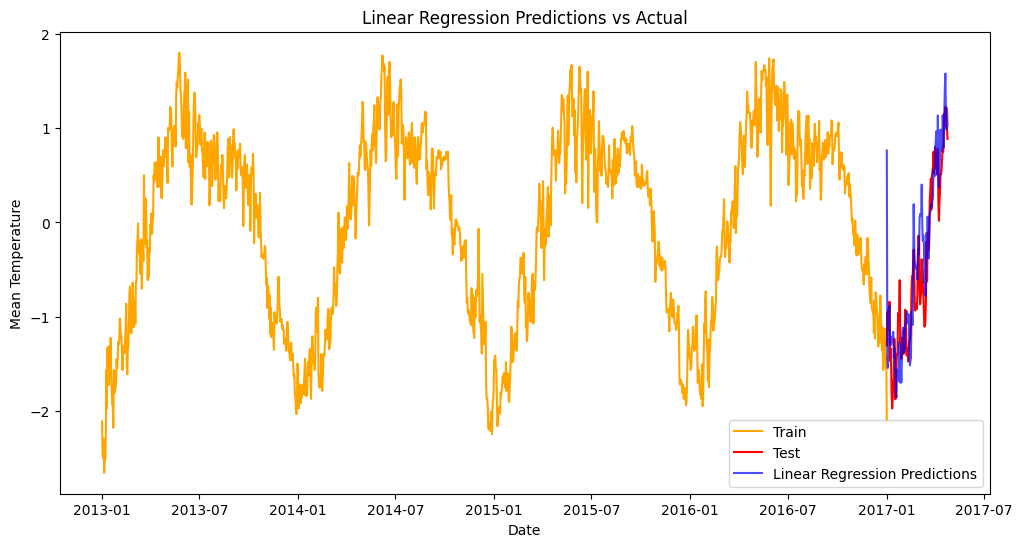

In [ ]:

df_train_scaled['date'] = df_train['date']
df_test_scaled['date'] = df_test['date']


#Linear Regression Predictions vs Actual

plt.figure(figsize=(12,6))
plt.plot(df_train_scaled['date'], df_train_scaled['meantemp'], label='Train', color='orange')
plt.plot(df_test_scaled['date'], df_test_scaled['meantemp'], label='Test', color='red')
plt.plot(df_test_scaled['date'], y_pred_lr, label='Linear Regression Predictions', color='blue', alpha=0.7)
plt.xlabel("Date")
plt.ylabel("Mean Temperature")
plt.title("Linear Regression Predictions vs Actual")
plt.legend()
plt.show()



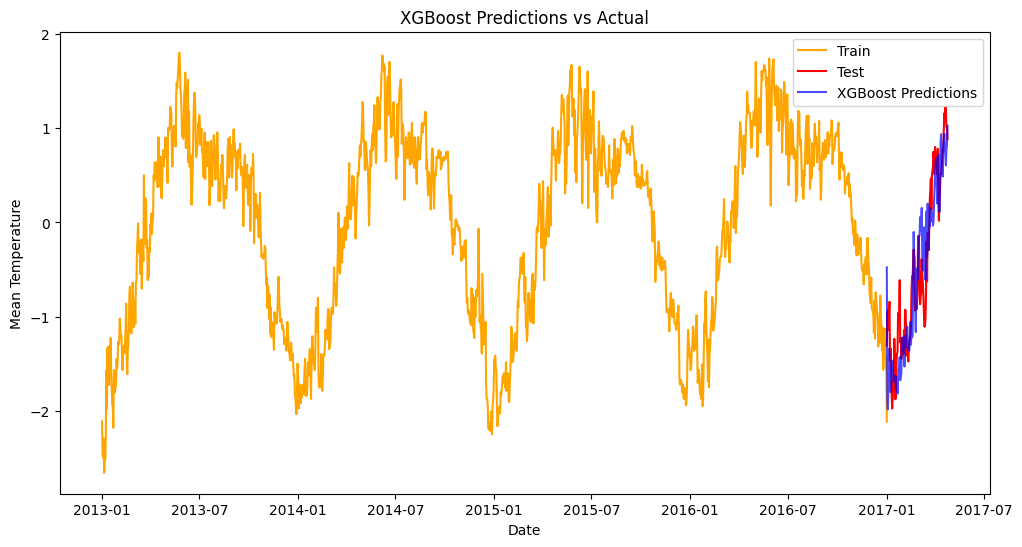

In [ ]:
#XGBoost Predictions vs Actual


plt.figure(figsize=(12,6))
plt.plot(df_train_scaled['date'], df_train_scaled['meantemp'], label='Train', color='orange')
plt.plot(df_test_scaled['date'], df_test_scaled['meantemp'], label='Test', color='red')
plt.plot(df_test_scaled['date'], y_pred_xgb, label='XGBoost Predictions', color='blue', alpha=0.7)
plt.xlabel("Date")
plt.ylabel("Mean Temperature")
plt.title("XGBoost Predictions vs Actual")
plt.legend()
plt.show()



In [ ]:
comparison_df = pd.DataFrame({
    "Model": ["Linear Regression",  "XGBoost"],
    "RMSE": [rmse_lr, rmse_xgb],
    "MAE":  [mae_lr,  mae_xgb],
    "R² Score": [r2_lr,  r2_xgb]
})

comparison_df

,Model,RMSE,MAE,R² Score
0,Linear Regression,0.414128,0.316974,0.769206
1,XGBoost,0.400702,0.324412,0.783928


<div style="
background:green;
padding:20px;
border-radius:12px;
box-shadow:0 4px 10px rgba(0,0,0,0.15);
font-size:34px;
font-weight:bold;
text-align:center;
color:white;">
    Conclusion
</div>


****Both models perform very well on the dataset****

****XGBoost is overall the better-performing model, as it provides slightly more accurate predictions lower RMSE,A stronger ability to explain variance higher R² score.****

<h1 style="
font-size:32px;
font-weight:bold;
background: linear-gradient(90deg, #3a7bd5, #6a11cb, #1f1c2c);
-webkit-background-clip: text;
color: transparent;
text-align:center;">
 ________________________________________________
 </h1>